In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_03.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_02.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_01.csv


In [2]:
df_train=pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
df_test=pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
df_prompts=pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')

In [3]:
df_train.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB


In [5]:
print(df_train.groupby(['generated','prompt_id']).count())

                      id  text
generated prompt_id           
0         0          707   707
          1          668   668
1         0            1     1
          1            2     2


In [6]:
df_train_1=pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_01.csv')
df_train_2=pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_02.csv')
df_train_3=pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_03.csv')
df_train_4=pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv')

In [7]:
text_size=[]
for i in df_train['text']:
  text_size.append(len(i))
text_size=pd.DataFrame(text_size, columns=['text_size'])
#text_size.head()
text_size.describe()
#print(text_size.mode())

,text_size
count,1378.000000
mean,3169.050798
std,920.588198
min,1356.000000
25%,2554.250000
50%,2985.500000
75%,3623.750000
max,8436.000000


In [8]:
train_1 = df_train_1[['text', 'label']]
train_1 = train_1.set_axis(['text', 'generated'], axis=1)
train_2 = df_train_2[['text', 'label']]
train_2 = train_2.set_axis(['text', 'generated'], axis=1)
train_3 = df_train_3[['text', 'label']]
train_3 = train_3.set_axis(['text', 'generated'], axis=1)
train_4 = df_train_4[['text', 'label']]
train_4 = train_4.set_axis(['text', 'generated'], axis=1)

df_train = df_train[['text', 'generated']]


In [9]:
df_train = pd.concat([train_1, train_2, train_3, train_4, df_train])
missing_values = df_train.isnull().sum()
print("missing_values_train:\n", missing_values)


missing_values_train:
 text         0
generated    0
dtype: int64


In [10]:
print(df_train.groupby(['generated']).count())

             text
generated        
0          116747
1           44087


In [11]:
from sklearn.model_selection import train_test_split
import tensorflow
import keras
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Text data preprocessing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['text'])
text_sequences = tokenizer.texts_to_sequences(df_train['text'])
X = pad_sequences(text_sequences,maxlen=2500)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [12]:
y=df_train['generated']

In [13]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
# Undersample the datapoints with generated value 0
undersampler = RandomUnderSampler(sampling_strategy=1)  # Set sampling_strategy to the desired ratio
X_resampled, y_resampled = undersampler.fit_resample(X,y)

# Combine the resampled data back into a DataFrame


# Print the count of each class after undersampling
print(y_resampled.value_counts())

generated
0    44087
1    44087
Name: count, dtype: int64


In [14]:

# Split the data into training and validation sets (adjust the test_size as needed)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_s, X_valid_s, y_train_s, y_valid_s = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [15]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Force TensorFlow to use GPU if available
if tf.test.is_gpu_available():
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    tf.compat.v1.Session(config=config)



# DNN model architecture (customize as needed)
input_layer = Input(shape=(X_train.shape[1],))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 501, output_dim=32)(input_layer)

conv1d_1 = Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.01))(embedding_layer)
conv1d_1 = BatchNormalization()(conv1d_1)
conv1d_1 = Dropout(0.2)(conv1d_1)
maxpooling_1 = GlobalMaxPooling1D()(conv1d_1)

flatten_layer = Flatten()(embedding_layer)
hidden_layer = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(flatten_layer)
hidden_layer = BatchNormalization()(hidden_layer)
hidden_layer = Dropout(0.2)(hidden_layer)

# Concatenate the results from Conv1D and Dense layers
concatenated = Concatenate()([maxpooling_1, hidden_layer])

output_layer = Dense(1, activation='sigmoid')(concatenated)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])

model_se = Model(inputs=input_layer, outputs=output_layer)

model_se.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2500)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 2500, 32)             3081536   ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 2496, 128)            20608     ['embedding[0][0]']           
                                                                                                  
 flatten (Flatten)           (None, 80000)                0         ['embedding[0][0]']           
                                                                                              

In [16]:
# Training the model

model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=512)

Epoch 1/10
252/252 [==============================] - 117s 419ms/step - loss: 0.4985 - accuracy: 0.9701 - val_loss: 0.5669 - val_accuracy: 0.9942
Epoch 2/10
252/252 [==============================] - 97s 386ms/step - loss: 0.1464 - accuracy: 0.9971 - val_loss: 0.1718 - val_accuracy: 0.9977
Epoch 3/10
252/252 [==============================] - 89s 354ms/step - loss: 0.0789 - accuracy: 0.9980 - val_loss: 0.0703 - val_accuracy: 0.9956
Epoch 4/10
252/252 [==============================] - 86s 341ms/step - loss: 0.0475 - accuracy: 0.9986 - val_loss: 0.1456 - val_accuracy: 0.9464
Epoch 5/10
252/252 [==============================] - 84s 333ms/step - loss: 0.0314 - accuracy: 0.9990 - val_loss: 0.0341 - val_accuracy: 0.9964
Epoch 6/10
252/252 [==============================] - 80s 317ms/step - loss: 0.0242 - accuracy: 0.9992 - val_loss: 0.0333 - val_accuracy: 0.9973
Epoch 7/10
252/252 [==============================] - 79s 314ms/step - loss: 0.0200 - accuracy: 0.9993 - val_loss: 0.1822 - val_a

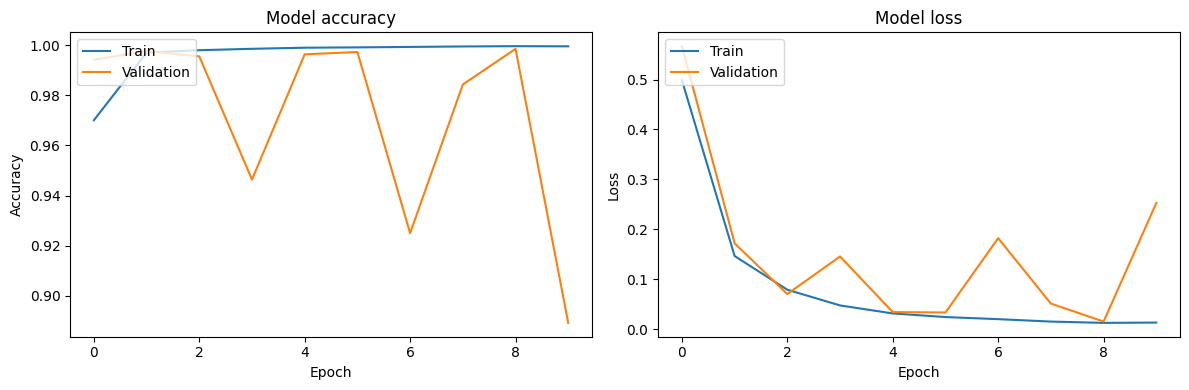

In [17]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [18]:
text_sequences = tokenizer.texts_to_sequences(df_test['text'])
X_test= pad_sequences(text_sequences, maxlen=2500)
# Initialize an array to store predictions for each fold
fold_preds = np.zeros(shape=(len(df_test),), dtype='float32')

y = model.predict(X_test)

fold_preds += y.squeeze()

1/1 [==============================] - 0s 187ms/step


In [19]:
sub_df = df_test[["id"]].copy()

# Add the formatted predictions to the submission DataFrame
sub_df["generated"] = fold_preds.squeeze()

sub_df.to_csv('submission.csv',index=False)

In [20]:
# Display the first 2 rows of the submission DataFrame
sub_df.head()

,id,generated
0,0000aaaa,0.999992
1,1111bbbb,0.999991
2,2222cccc,0.999991
